In [22]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [23]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [24]:
from __future__ import print_function
from numpy import *
from scipy import *
import netCDF4 as nc
import numpy as np
import scipy as sp
import seawater
import datetime as dt

""
from salishsea_tools import (
    nc_tools,
    viz_tools, 
    geo_tools,
    tidetools
)
from salishsea_tools import visualisations as vis
import matplotlib.pyplot as plt
#matplotlib.use('Agg')
import matplotlib.patches as patches
plt.style.use('seaborn-whitegrid')
import netCDF4 as nc

import cmocean as cm
import glob
import sys
sys.path.append('/data/tjarniko/mocsy')
sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/CCCmaDEV/CCCma_src')
sys.path.append('/data/tjarniko/MEOPAR/tools/SalishSeaTools/salishsea_tools/')
import mocsy
import river_201702 as rv
import mocsy
import CCCma
import CCCma_stations as cs
from matplotlib import reload
import arrow
import gsw
import datetime as dt

%matplotlib inline

In [25]:
def make_nclen(start,end,ftype, sdir):
    date_ar = []
    sens_ar = []
    doy_ar = []
    start_run = arrow.get(start)
    end_run = arrow.get(end)
    arrow_array = []
    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)
    for i in range(0,dayslen):
        tdate = arrow_array[i][0]
        ddmmmyy = tdate.format('DDMMMYY').lower()
        ymd = tdate.format('YYYYMMDD')
        dddd = tdate.format('DDDD')
        nc_sens = sdir + '/SKOG_1d_*'+ ftype +'*' + ymd + '-' + ymd + '.nc'
        tnc_sens = glob.glob(nc_sens)
        sens_ar.append(tnc_sens[0])
        date_ar.append(ddmmmyy)
        doy_ar.append(dddd)
    return date_ar, sens_ar, doy_ar

In [26]:
def oned_moxy(tsal, ttemp, tdic, tta, pres_atm, depth_this):

    size_box = np.shape(tdic)
    size_0 = size_box[0]
    size_1= size_box[1]
    size_2 = size_box[2]

    tsra = np.ravel(tsal)
    ttera = np.ravel(ttemp)
    ttara = np.ravel(tta) * 1e-3
    tdra = np.ravel(tdic) * 1e-3
    tzero = np.zeros_like(tsra)
    tpressure = np.zeros_like(tsra)
    #tdepth = np.zeros_like(tsra)
    tpressure[:] = pres_atm
    tdepth = np.ravel(depth_this)
    tzero = tpressure * 0 
        
    tsra_psu = tsra*35/35.16504
    ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

    response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    pHr = pH.reshape(size_0,size_1,size_2)
    OmAr = OmegaA.reshape(size_0,size_1,size_2)
    pco2r = pco2.reshape(size_0,size_1,size_2)
    
    return pHr, OmAr, pco2r

In [27]:
start = '2015-01-01'
end = '2015-12-30'

st = dt.datetime(2015,1,1)
en = dt.datetime(2015,12,30)

y_st = st.timetuple().tm_yday
print(y_st)
y_en = en.timetuple().tm_yday
print(y_en)
ts_BR = np.arange(y_st,y_en+1,1)

sdir_preind = '/data/tjarniko/results/PREIND_2nd_2015/PI_2/ncs/'
sdir_br = '/data/tjarniko/results/BR_2nd_2015_cop/SKOG_2/ncs'

dates_preind_carp, files_preind_carp, doy_preind = make_nclen(start,end,'carp', sdir_preind)
dates_br_carp, files_br_carp, doy_br = make_nclen(start,end,'carp', sdir_br)
dates_preind_grid, files_preind_grid, doy_preind = make_nclen(start,end,'grid_T', sdir_preind)
dates_br_grid, files_br_grid, doy_br = make_nclen(start,end,'grid_T', sdir_br)

1
364


In [28]:
test_br_grid = nc.Dataset(files_br_grid[0])
test_br_carp = nc.Dataset(files_br_carp[0])
test_preind_grid = nc.Dataset(files_preind_grid[0])
test_preind_carp = nc.Dataset(files_preind_carp[0])

depth_t = test_br_grid['deptht'][:]

a = 40
b = 898
c = 398
d = depth_t
depth_broad = np.empty((a, b, c))
for b in range(0,898):
    for c in range(0,398):
        depth_broad[:,b,c] = depth_t

In [29]:
DIC_br = test_br_carp['dissolved_inorganic_carbon'][0,:,:,:]
TA_br = test_br_carp['total_alkalinity'][0,:,:,:]
SAL_br = test_br_grid['vosaline'][0,:,:,:]
TEMP_br = test_br_grid['votemper'][0,:,:,:]

DIC_preind = test_preind_carp['dissolved_inorganic_carbon'][0,:,:,:]
TA_preind = test_preind_carp['total_alkalinity'][0,:,:,:]
SAL_preind = test_preind_grid['vosaline'][0,:,:,:]
TEMP_preind = test_preind_grid['votemper'][0,:,:,:]

pHr_preind, OmAr_preind, pco2r_preind = oned_moxy(SAL_preind, TEMP_preind, DIC_preind, TA_preind, 1, depth_broad)
pHr_br, OmAr_br, pco2r_br = oned_moxy(SAL_br, TEMP_br, DIC_br, TA_br, 1, depth_broad)

bathy = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

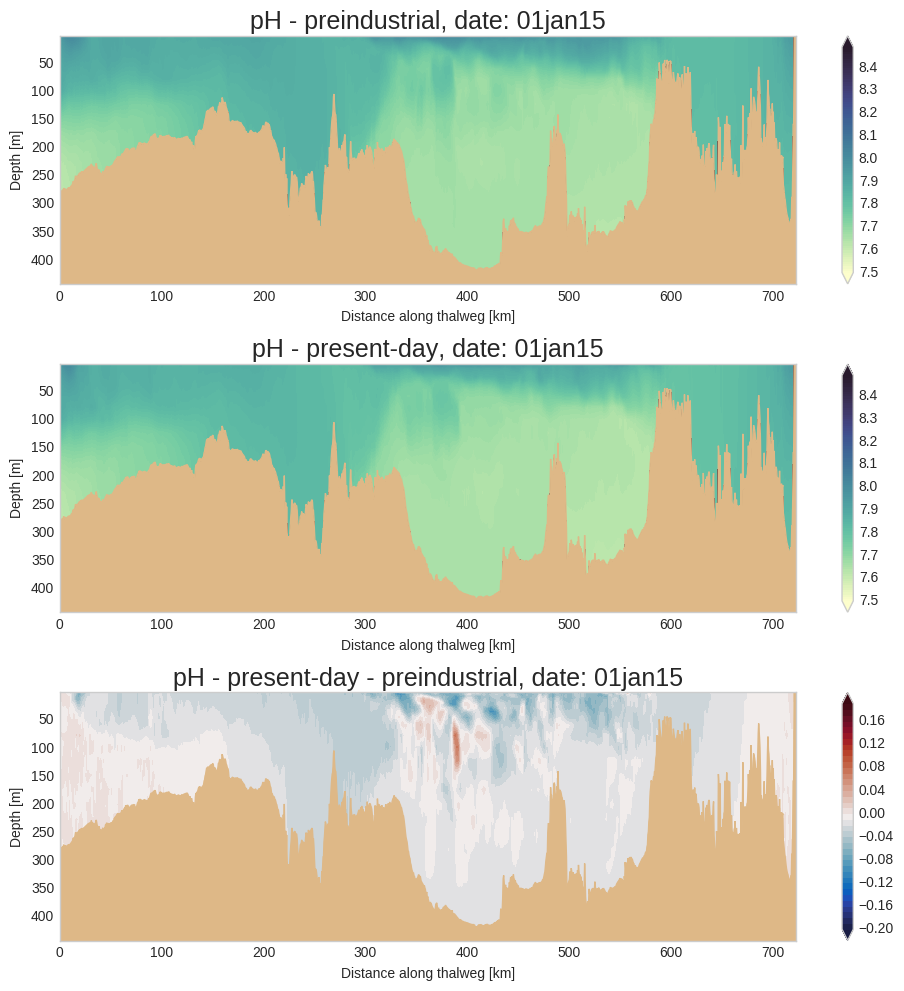

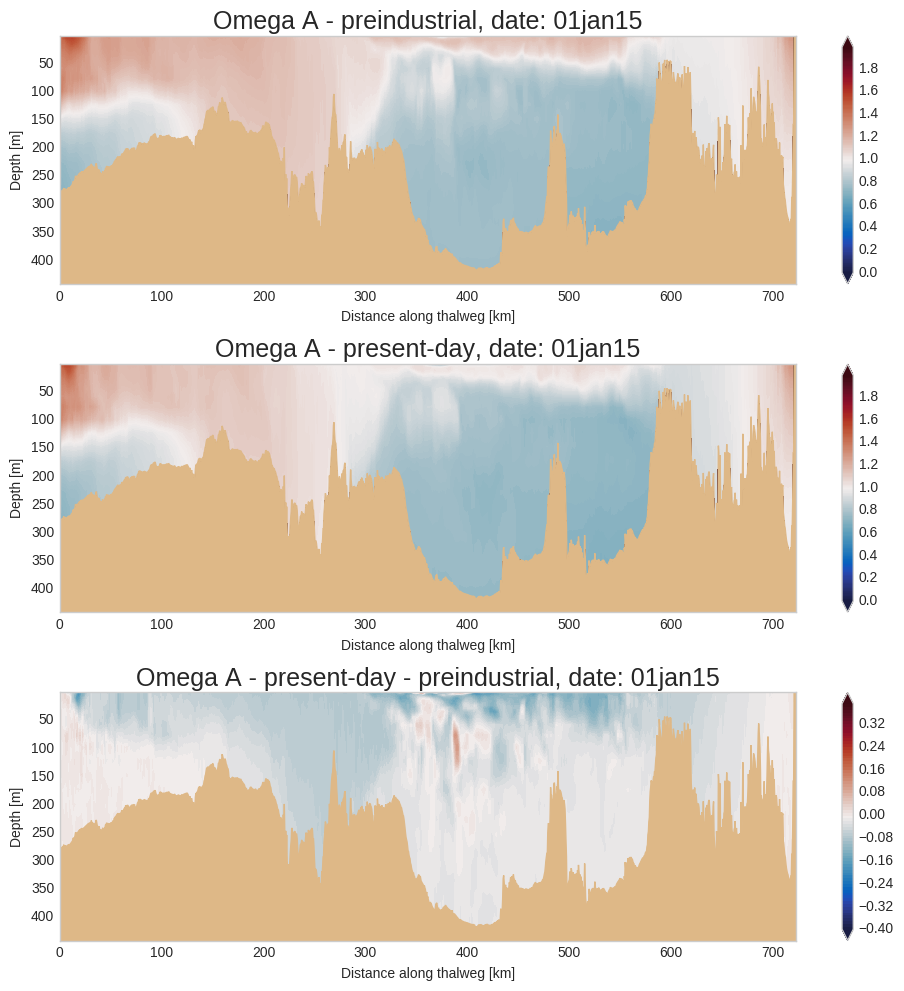

In [30]:

t_cmap = cm.cm.deep
t_vmin = 7.5
t_vmax = 8.5
stepsize = 0.01
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,10))
vis.contour_thalweg(ax1, pHr_preind, bathy, mesh, np.arange(t_vmin, t_vmax, stepsize), cmap = t_cmap)
ax1.set_title('pH - preindustrial, date: '+dates_br_carp[0], fontsize = 18)

t_cmap = cm.cm.deep
t_vmin = 7.5
t_vmax = 8.5
stepsize = 0.01
vis.contour_thalweg(ax2, pHr_br, bathy, mesh, np.arange(t_vmin, t_vmax, stepsize), cmap = t_cmap)
ax2.set_title('pH - present-day, date: '+dates_br_carp[0], fontsize = 18)

t_cmap = cm.cm.balance
t_vmin = -0.2
t_vmax = 0.2
stepsize = 0.01
vis.contour_thalweg(ax3, pHr_br - pHr_preind, bathy, mesh, np.arange(t_vmin, t_vmax, stepsize), cmap = t_cmap)
ax3.set_title('pH - present-day - preindustrial, date: '+dates_br_carp[0], fontsize = 18)

fig.tight_layout()


t_cmap_OmA = cm.cm.balance
t_vmin_OmA = 0
t_vmax_OmA = 2
stepsize = 0.01
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,10))
vis.contour_thalweg(ax1, OmAr_preind, bathy, mesh, np.arange(t_vmin_OmA, t_vmax_OmA, stepsize), cmap = t_cmap)
ax1.set_title('Omega A - preindustrial, date: '+dates_br_carp[0], fontsize = 18)

t_cmap = cm.cm.balance
t_vmin_OmA = 0
t_vmax_OmA = 2
stepsize = 0.01
vis.contour_thalweg(ax2, OmAr_br, bathy, mesh, np.arange(t_vmin_OmA, t_vmax_OmA, stepsize), cmap = t_cmap)
ax2.set_title('Omega A - present-day, date: '+dates_br_carp[0], fontsize = 18)

t_cmap = cm.cm.balance
t_vmin = -0.4
t_vmax = 0.4
stepsize = 0.01
vis.contour_thalweg(ax3, OmAr_br - OmAr_preind, bathy, mesh, np.arange(t_vmin, t_vmax, stepsize), cmap = t_cmap)
ax3.set_title('Omega A - present-day - preindustrial, date: '+dates_br_carp[0], fontsize = 18)

fig.tight_layout()

In [31]:
# thalweg_file='/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt'
# thalweg_pts = np.loadtxt(thalweg_file, delimiter=' ', dtype=int)
# jss = thalweg_pts[:, 0]
# iss = thalweg_pts[:, 1]

# t_dat = test_file['dissolved_inorganic_carbon'][0,:,jss,iss]
# plt.plot(t_dat)

then run bash mov5.sh ./FLUX_plot/ TWGDIFF_OmA_2015spunup_


In [32]:
from salishsea_tools import visualisations as vis
bathy = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

startplot = 328

for i in range(startplot,len(doy_br)):

    print(i)
    test_br_grid = nc.Dataset(files_br_grid[i])
    test_br_carp = nc.Dataset(files_br_carp[i])
    test_preind_grid = nc.Dataset(files_preind_grid[i])
    test_preind_carp = nc.Dataset(files_preind_carp[i])
    doy = doy_br[i]
    tdate = dates_br_carp[i]

    DIC_br = test_br_carp['dissolved_inorganic_carbon'][0,:,:,:]
    TA_br = test_br_carp['total_alkalinity'][0,:,:,:]
    SAL_br = test_br_grid['vosaline'][0,:,:,:]
    TEMP_br = test_br_grid['votemper'][0,:,:,:]

    DIC_preind = test_preind_carp['dissolved_inorganic_carbon'][0,:,:,:]
    TA_preind = test_preind_carp['total_alkalinity'][0,:,:,:]
    SAL_preind = test_preind_grid['vosaline'][0,:,:,:]
    TEMP_preind = test_preind_grid['votemper'][0,:,:,:]

    pHr_preind, OmAr_preind, pco2r_preind = oned_moxy(SAL_preind, TEMP_preind, DIC_preind, TA_preind, 1, depth_broad)
    pHr_br, OmAr_br, pco2r_br = oned_moxy(SAL_br, TEMP_br, DIC_br, TA_br, 1, depth_broad)
    
    t_cmap = cm.cm.deep
    t_vmin = 7.5
    t_vmax = 8.5
    stepsize = 0.01
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,10))
    vis.contour_thalweg(ax1, pHr_preind, bathy, mesh, np.arange(t_vmin, t_vmax, stepsize), cmap = t_cmap)
    ax1.set_title('pH - preindustrial, date: '+dates_br_carp[i], fontsize = 18)

    t_cmap = cm.cm.deep
    t_vmin = 7.5
    t_vmax = 8.5
    stepsize = 0.01
    vis.contour_thalweg(ax2, pHr_br, bathy, mesh, np.arange(t_vmin, t_vmax, stepsize), cmap = t_cmap)
    ax2.set_title('pH - present-day, date: '+dates_br_carp[i], fontsize = 18)

    t_cmap = cm.cm.balance
    t_vmin = -0.2
    t_vmax = 0.2
    stepsize = 0.01
    vis.contour_thalweg(ax3, pHr_br - pHr_preind, bathy, mesh, np.arange(t_vmin, t_vmax, stepsize), cmap = t_cmap)
    ax3.set_title('pH - present-day - preindustrial, date: '+dates_br_carp[i], fontsize = 18)

    fig.tight_layout()
    fname = './TWG_DIFF/TWGDIFF_pH_2015spunup_' + doy +'.png'

    fig.savefig(fname)
    plt.close()

    t_cmap_OmA = cm.cm.balance
    t_vmin_OmA = 0
    t_vmax_OmA = 2
    stepsize = 0.01
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,10))
    vis.contour_thalweg(ax1, OmAr_preind, bathy, mesh, np.arange(t_vmin_OmA, t_vmax_OmA, stepsize), cmap = t_cmap)
    ax1.set_title('Omega A - preindustrial, date: '+dates_br_carp[i], fontsize = 18)

    t_cmap = cm.cm.balance
    t_vmin_OmA = 0
    t_vmax_OmA = 2
    stepsize = 0.01
    vis.contour_thalweg(ax2, OmAr_br, bathy, mesh, np.arange(t_vmin_OmA, t_vmax_OmA, stepsize), cmap = t_cmap)
    ax2.set_title('Omega A - present-day, date: '+dates_br_carp[i], fontsize = 18)

    t_cmap = cm.cm.balance
    t_vmin = -0.4
    t_vmax = 0.4
    stepsize = 0.01
    vis.contour_thalweg(ax3, OmAr_br - OmAr_preind, bathy, mesh, np.arange(t_vmin, t_vmax, stepsize), cmap = t_cmap)
    ax3.set_title('Omega A - present-day - preindustrial, date: '+dates_br_carp[i], fontsize = 18)

    fig.tight_layout()
    fname = './TWG_DIFF/TWGDIFF_OmA_2015spunup_' + doy +'.png'

    fig.savefig(fname)
    plt.close()

328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363


IndexError: 

In [ ]:
#190

In [39]:
test_preind_carp = nc.Dataset(files_preind_carp[363])
print(test_preind_carp)
print(files_preind_carp[363])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    name: SKOG_1d_20151126_20151231_carp_T
    description: auxilary variables
    title: auxilary variables
    Conventions: CF-1.6
    timeStamp: 2019-May-22 20:58:30 GMT
    uuid: ceb2621f-b6c0-484f-a62d-7309d0094429
    dimensions(sizes): axis_nbounds(2), x(398), y(898), nvertex(4), deptht(40), time_counter(0)
    variables(dimensions): float32 nav_lat(y,x), float32 nav_lon(y,x), float32 bounds_nav_lon(y,x,nvertex), float32 bounds_nav_lat(y,x,nvertex), float32 area(y,x), float32 deptht(deptht), float32 deptht_bounds(deptht,axis_nbounds), float64 time_centered(time_counter), float64 time_centered_bounds(time_counter,axis_nbounds), float64 time_counter(time_counter), float64 time_counter_bounds(time_counter,axis_nbounds), float32 PAR(time_counter,deptht,y,x), float32 sigma_theta(time_counter,deptht,y,x), float32 e3t(time_counter,deptht,y,x), float32 dissolved_inorganic_carbon(time_counter,deptht,y,x